# PINNs on Graphs

Import necessary packages.

In [7]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

Define solver for PINNs.

## 1st step: Solve easy stationary equation

In [146]:
DTYPE = 'float32'

# Specify adjacency matrix
A = tf.constant([[0, 1, 1, 1],
                 [1, 0, 0, 0],
                 [1, 0, 0, 0],
                 [1, 0, 0, 0]], dtype=tf.int16)

n_nodes = A.shape[0]

# Edges
E = tf.constant([[0, 1],
                 [0, 2],
                 [0, 3]], dtype=tf.int16)

# Weights
W = tf.constant([1,
                 1,
                 1], dtype=DTYPE)

V = tf.constant([[0., 0.],
                 [1., 0.],
                 [np.sqrt(2)/2, np.sqrt(2)/2],
                 [0., 1.]], dtype=DTYPE)

Dirichlet_nodes = tf.constant([0], dtype=tf.int16)
Dirichlet_vals = tf.constant([0.], dtype=DTYPE)

In [147]:
# Bounds for parameter lambda
lb = tf.constant([0.], dtype=DTYPE)
ub = tf.constant([1.], dtype=DTYPE)

N_r = 50

In [148]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)

        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

### Version 1: One NN on each edge

In [149]:
NNs = []
for i,e in enumerate(E):
    NNs.append(PINN_NeuralNet(lb=lb, ub=ub))
    
print('Initialized {:d} neural nets.'.format(len(NNs)))

Initialized 3 neural nets.


Set up solver class.

In [153]:
class PINNSolver(object):
    def __init__(self, NNs, N_r):
        self.NNs = NNs

        # Store collocation points
        self.N_r = N_r
        
        self.N_e = len(NNs)
        
        self.x = [tf.linspace(NNs[i].lb, NNs[i].ub, N_r+1)
                      for i in range(self.N_e)]
        
        #self.x = [X_r[:, i:i+1] for i in range(self.model.dim)]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        self.trainable_variables = [self.NNs[i].trainable_variables
                                    for i in range(self.N_e)]
    
    def get_fvals(self):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u2x = []
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.N_e):
                u.append(self.NNs[i](self.x[i]))
                u1x.append(tape.gradient(u[i], self.x[i]))
                
        for i in range(self.N_e):
            u2x.append(tape.gradient(u1x[i], self.x[i]))
        
        del tape

        return u, u1x, u2x
    
    def fun_r(self, u, u1x, u2x):
        ret = []
        for i in range(self.N_e):
            ret.append(-u2x[i] + 1 * u[i] - 0.5)
        return ret
    
    def loss_fn(self):
        # Get values of functions and derivatives
        u, u1x, u2x = self.get_fvals()
        
        # Compute phi_r
        r = self.fun_r(u, u1x, u2x)
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r
        
        
        # Values equal in center node
        loss += tf.reduce_mean(tf.square(u[0][0]-u[1][0]))
        loss += tf.reduce_mean(tf.square(u[0][0]-u[2][0]))
        loss += tf.reduce_mean(tf.square(u[1][0]-u[2][0]))
        
        
        # Kirchhoff-Neumann condition
        loss += tf.reduce_mean(tf.square(u1x[0][0] + u1x[1][0] + u1x[2][0]))
        
        # Multiple leaves are Dirichlet nodes
        loss += tf.reduce_mean(tf.square(u[0][-1]-0.0))
        #loss += tf.reduce_mean(tf.square(u[1][-1]-1.0))
        #loss += tf.reduce_mean(tf.square(u[2][-1]-2.0))



        #for i in range(self.N_e):    
            #loss += tf.reduce_mean(tf.square(u[i]))

        return loss
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""

        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.N_e):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            

    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(self.N_e):
                for v in self.NNs[i].variables:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for i in range(self.N_e):
                for v in self.NNs[i].variables:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, tf.float32))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()

            # Flatten gradient
            grad_flat = []
            for i in range(self.N_e):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

            
    
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(
                self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1
        

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [154]:
pinn = PINNSolver(NNs, N_r=N_r)
#pinn.loss_fn()
loss, grad=pinn.get_grad()
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
pinn.solve_with_TFoptimizer(optim, N=201)
print('End with L-BFGS-B algorithm')
pinn.solve_with_ScipyOptimizer()

Start with TF optimizer

It 00000: loss = 9.50565696e-01
It 00050: loss = 9.25096683e-03
It 00100: loss = 3.67817585e-04
It 00150: loss = 1.21106466e-04
It 00200: loss = 7.63317148e-05
End with L-BFGS-B algorithm
It 00250: loss = 1.23197578e-05
It 00300: loss = 3.14588988e-06
It 00350: loss = 2.10346548e-06
It 00400: loss = 1.12393616e-06


      fun: 1.029252644002554e-06
 hess_inv: <9003x9003 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.51535743e-06,  4.26602855e-06, -5.21711900e-06, ...,
        4.74521403e-05,  5.93751574e-05,  1.05363462e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 234
      nit: 211
   status: 0
  success: True
        x: array([0.15590597, 0.26276336, 0.40070489, ..., 0.41042482, 0.43992706,
       0.00131107])

Next, we try to plot the results.

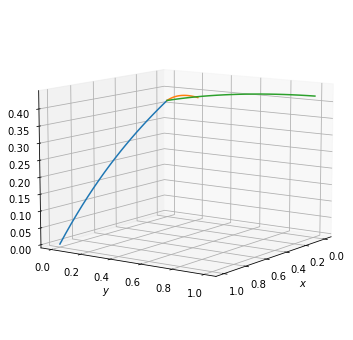

In [155]:
%matplotlib inline
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
N = 20
lmbd = tf.linspace(lb[0], ub[0], N + 1)
Lmbd = tf.reshape(lmbd, [-1, 1])

for i, e in enumerate(E):
    xy = V[e[0].numpy()]+Lmbd*(V[e[1].numpy()]-V[e[0].numpy()])
    u = pinn.NNs[i](Lmbd)
    unum = u.numpy().flatten()
    ax.plot(xy[:,0], xy[:,1], unum)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#ax.set_zlabel('$u_\\theta(x,y)$')
ax.view_init(10, 35)

## 2. Solve easy instationary equation